# Testting integration runtime
---
### Delete upon merge?!

In [1]:
import os
import sys
import torch

# pylint: disable=wrong-import-position
sys.path.append(os.path.realpath('.'))
sys.path.append(os.path.join(os.path.expanduser('~'), 'bnelearn'))

from bnelearn.util.metrics import norm_actions

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from torchquad import enable_cuda # Necessary to enable GPU support
from torchquad import Simpson, Boole
import torchquad
enable_cuda()


In [2]:
device = 'cuda:0'  # TODO there's an issue somewhere st notebook only works on 0

# Calculate high precision baseline and write to disk
base_batch_size = 2**12
n_players = 2
prior = torch.distributions.Normal(
    torch.tensor(15.0, device=device),
    torch.tensor(5.0, device=device)
)
prior_cdf = prior.cdf
Fpowered = lambda v: torch.pow(prior_cdf(torch.tensor(v, device=device)), n_players - 1)

In [27]:
# heavy workload
valuation = prior.sample((base_batch_size,)).relu_()  # TODO torch quad needs non-negative?! 
baseline_sol = torch.tensor(
    [integrate.quad(Fpowered, 0, v)[0] for v in valuation],
    device=device
).view_as(valuation)
torch.save(baseline_sol, 'baseline_sol.pt')
torch.save(valuation, 'valuation.pt')

<ipython-input-27-21610ee4ea52>:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  [integrate.quad(Fpowered, 0, v)[0] for v in valuation],


In [3]:
baseline_sol = torch.load('baseline_sol.pt').to(device=device)
valuation = torch.load('valuation.pt').to(device=device)

<ipython-input-7-0095dac9522f>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Fpowered = lambda v: torch.pow(prior_cdf(torch.tensor(v, device=device)), n_players - 1)
<ipython-input-7-0095dac9522f>:38: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  numerator = [integrate.quad(Fpowered, 0, v)[0] for v in valuation_sample]
<ipython-input-7-0095dac9522f>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Fpowered = lambda v: torch.pow(prior_cdf(torch.tensor(v, device=device)), n_players - 1)
<ipython-input-7-0095dac9522f>:2: UserWarning: To copy construct from a tensor, i

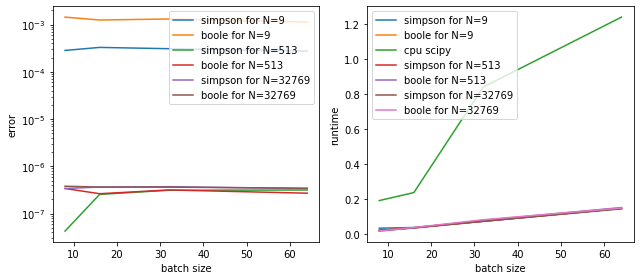

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
Fpowered = lambda v: torch.pow(prior_cdf(torch.tensor(v, device=device)), n_players - 1)
Ns = [2**x + 1 for x in [3, 9, 15]]
batch_sizes = [2**x for x in range(3, 7)]
for N in Ns:
    simpson_errors = np.zeros(len(batch_sizes))
    boole_errors = np.zeros(len(batch_sizes))
    scipy_errors = np.zeros(len(batch_sizes))
    simpson_time = np.zeros(len(batch_sizes))
    boole_time = np.zeros(len(batch_sizes))
    scipy_time = np.zeros(len(batch_sizes))
    for i, batch_size in enumerate(batch_sizes):
        valuation_sample = valuation[:batch_size, ...]

        simpson = Simpson()
        s = time.time()
        numerator_s = [
            simpson.integrate(Fpowered, dim=1, N=N, integration_domain=[[0, v.item()]])
            for v in valuation_sample
        ]
        # print(f"Simpson took {(time.time()-s) * 1000.0:.3f} ms")
        numerator_s = torch.tensor(numerator_s, device=device).view_as(valuation_sample)
        simpson_errors[i] = norm_actions(numerator_s, baseline_sol[:batch_size, ...])
        simpson_time[i] = time.time() - s

        boole = Boole()
        s = time.time()
        numerator_b = [boole.integrate(Fpowered, dim=1, N=N, integration_domain=[[0, v.item()]])
            for v in valuation_sample
        ]
        # print(f"Boole took {(time.time()-s) * 1000.0:.3f} ms")
        numerator_b = torch.tensor(numerator_b, device=device).view_as(valuation_sample)
        boole_errors[i] = norm_actions(numerator_b, baseline_sol[:batch_size, ...])
        boole_time[i] = time.time() - s

        if N == Ns[0] and batch_size <= 2**11:
            s = time.time()
            numerator = [integrate.quad(Fpowered, 0, v)[0] for v in valuation_sample]
            # print(f"Scipy took {(time.time()-s) * 1000.0:.3f} ms")
            numerator = torch.tensor(numerator, device=device).view_as(valuation_sample)
            # scipy_errors[i] = norm_actions(numerator, baseline_sol[:batch_size, ...])
            scipy_time[i] = time.time() - s
        
    axs[0].plot(batch_sizes, simpson_errors, label=f'simpson for N={N}')
    axs[0].plot(batch_sizes, boole_errors, label=f'boole for N={N}')
    axs[1].plot(batch_sizes, simpson_time, label=f'simpson for N={N}')
    axs[1].plot(batch_sizes, boole_time, label=f'boole for N={N}')
    if N == Ns[0]:
        axs[1].plot(batch_sizes, scipy_time, label=f'cpu scipy')
axs[0].legend(loc='upper right')
axs[0].set_xlabel('batch size')
axs[0].set_yscale('log')
axs[0].set_ylabel('error')
axs[1].legend(loc='upper left')
axs[1].set_xlabel('batch size')
axs[1].set_ylabel('runtime')
plt.tight_layout()
plt.show()